<a href="https://colab.research.google.com/github/saurabh-parkar/Time-Series-Forecasting-for-Energy-Prediction/blob/master/Time_Series_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

In [0]:
import pandas as pd
from collections import deque
import random
import numpy as np
from sklearn import preprocessing

In [0]:
df = pd.read_csv('/content/drive/My Drive/Ashrae data/train_tidy.csv')

In [0]:
df = df.drop('Unnamed: 0', axis = 1)

# 1. Setting up the problem
Here I will be trying to predict energy meter values for one time series instance, that is for a particular building and a meter type. I have randomly chosen building_id = 280 for this example.

In [0]:
df105 = df[ (df['meter'] == 0) & (df['building_id']== 280) ]

In [0]:
df105.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,weekend,is_holiday
330,280,0,17.26,2,1,11.566523,15.6,6.000000,-5.6,0.0,1015.3,270.0,3.6,0,4,1
2524,280,0,17.20,2,1,11.566523,13.9,0.869565,-5.6,0.0,1015.6,270.0,4.1,1,4,0
4714,280,0,17.46,2,1,11.566523,13.3,2.000000,-5.6,0.0,1016.0,270.0,3.1,2,4,0
6907,280,0,17.47,2,1,11.566523,12.2,0.000000,-6.1,0.0,1016.6,280.0,3.1,3,4,0
9097,280,0,17.95,2,1,11.566523,11.7,2.000000,-6.7,0.0,1017.0,270.0,3.1,4,4,0


In [0]:
df105 = df105[['building_id',	'meter', 'site_id',	'primary_use',	'square_feet',	'air_temperature'	,'cloud_coverage',	'dew_temperature',	'precip_depth_1_hr',	'sea_level_pressure',	'wind_direction',	'wind_speed',	'hour',	'weekend',	'is_holiday', 'meter_reading']]

In [0]:
df105.head(20)

,meter,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,is_holiday,meter_reading
330,0,1,11.566523,15.6,6.000000,-5.6,0.0,1015.3,270.0,3.6,1,17.26
2524,0,1,11.566523,13.9,0.869565,-5.6,0.0,1015.6,270.0,4.1,0,17.20
4714,0,1,11.566523,13.3,2.000000,-5.6,0.0,1016.0,270.0,3.1,0,17.46
6907,0,1,11.566523,12.2,0.000000,-6.1,0.0,1016.6,280.0,3.1,0,17.47
9097,0,1,11.566523,11.7,2.000000,-6.7,0.0,1017.0,270.0,3.1,0,17.95
11288,0,1,11.566523,10.0,0.000000,-6.7,0.0,1017.2,260.0,1.5,0,17.63
13477,0,1,11.566523,9.4,0.000000,-6.1,0.0,1017.4,0.0,0.0,0,17.49
15662,0,1,11.566523,7.2,0.000000,-5.6,0.0,1017.3,0.0,0.0,0,17.70
17853,0,1,11.566523,7.2,0.000000,-6.7,0.0,1017.0,50.0,1.5,0,24.83
20043,0,1,11.566523,6.1,0.000000,-5.0,0.0,1016.9,0.0,0.0,0,46.16


# 2. Preprocessing 

## Dropping useless columns
When we subset the data using a particular building and a meter type few of the columns like building_id, meter, site_id etc. will have the same value for all the observations. So its better to just drop these columns to avoid any unintended effect on our model.

In [0]:
df105 = df105.drop(['hour', 'weekend' , 'meter'	, 'building_id'], axis = 1)

In [0]:
df105 = df105.drop(['building_id', 	'meter', 	'site_id', 	'primary_use',	'square_feet', 'hour', 'weekend'], axis = 1)

The null values were already resolved in the preprocessing part

In [0]:
df105.isnull().any()

air_temperature       False
cloud_coverage        False
dew_temperature       False
precip_depth_1_hr     False
sea_level_pressure    False
wind_direction        False
wind_speed            False
is_holiday            False
meter_reading         False
dtype: bool

## Splitting the data into train and test sets
I will be using the last 0.05% of the dataset as the testing set.
For time series data, it is important to preserve the correct order of the dataset while splitting. Therefore shuffling the data or using cross-validation does not apply here.

In [0]:
splitter = sorted(df105.index.values)[-int(0.05*len(df105))]

test_df = df105[(df105.index >= splitter)]  # make the validation data where the index is in the last 5%
main_df = df105[(df105.index < splitter)] 

## Visualizing the time series

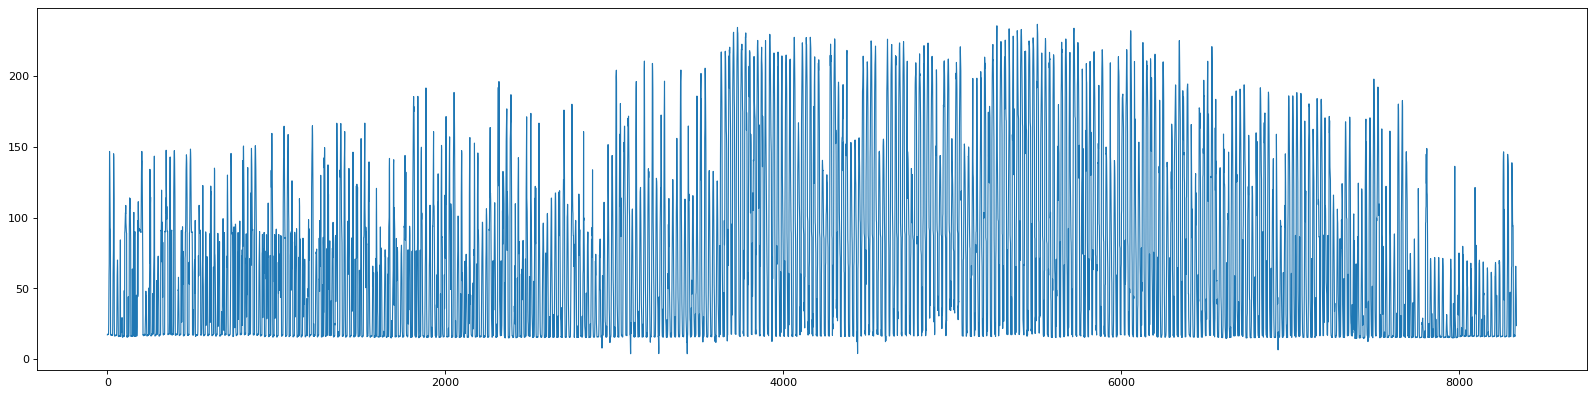

In [0]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
from collections import deque
import numpy as np
import random

x = np.array([i for i in range(len(main_df))])
y = main_df['meter_reading']
from matplotlib.pyplot import figure
figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x,y, linewidth=1)
plt.show()

The dataset consists of observations taken over just a one-year timeframe which is not enough to capture a significant trend or seasonality.

## Scaling the data

I iterate over all the columns in the dataset and standardize the values i.e. transform the values to have a 0 mean and a unit variance. This brings the values to the same scale eliminating any sparsity. This is a common preprocessing step used in time series and other sequence data.

Another common preprocessing method used in time series is the pct_change which replaces the values by percentage change between the current and a prior element.



In [0]:
SEQ_LEN = 20

for col in main_df.columns:  # go through all of the columns
    if col not in ["meter_reading", "is_holiday"]:
        #df[col] = df[col].pct_change() 
        main_df[col] = preprocessing.scale(main_df[col].values)




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were 

## Building the data

Next we start building the data. For this we will be using the last 10 observations to predict the current meter reading. This will be done as follows-

![alt text](https://drive.google.com/uc?id=146Mj17yRgJJTmDI3z6-XxGMLTLtJ2bYo)
![alt text](https://drive.google.com/uc?id=1c8oVucMxq--9kpF7d2-3fx4Xv8g57cbw)

The red box represents the features and the green box represents the target.The features will be stored as a list containing observations of previous 10 timesteps. Then we move both the boxes one step down and we get our second observation and its corresponding target. In this way, we generate our feature data and target data for both train and test sets.


In [0]:
sequential_data = [] 
prev_days = deque(maxlen=SEQ_LEN) 

for i in main_df.values:
    prev_days.append([n for n in i[:-1]])
    if len(prev_days) == SEQ_LEN:
        sequential_data.append([np.array(prev_days), i[-1]])

#random.shuffle(sequential_data)

In [0]:
X = []
y = []

for seq, target in sequential_data:  # going over our new sequential data
    X.append(seq)  # X is the sequences
    y.append(target)

In [0]:
train_x = np.array(X)
train_y = y

In [0]:
df105.head(20)

,meter,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,is_holiday,meter_reading
330,0,1,11.566523,15.6,6.000000,-5.6,0.0,1015.3,270.0,3.6,1,17.26
2524,0,1,11.566523,13.9,0.869565,-5.6,0.0,1015.6,270.0,4.1,0,17.20
4714,0,1,11.566523,13.3,2.000000,-5.6,0.0,1016.0,270.0,3.1,0,17.46
6907,0,1,11.566523,12.2,0.000000,-6.1,0.0,1016.6,280.0,3.1,0,17.47
9097,0,1,11.566523,11.7,2.000000,-6.7,0.0,1017.0,270.0,3.1,0,17.95
11288,0,1,11.566523,10.0,0.000000,-6.7,0.0,1017.2,260.0,1.5,0,17.63
13477,0,1,11.566523,9.4,0.000000,-6.1,0.0,1017.4,0.0,0.0,0,17.49
15662,0,1,11.566523,7.2,0.000000,-5.6,0.0,1017.3,0.0,0.0,0,17.70
17853,0,1,11.566523,7.2,0.000000,-6.7,0.0,1017.0,50.0,1.5,0,24.83
20043,0,1,11.566523,6.1,0.000000,-5.0,0.0,1016.9,0.0,0.0,0,46.16


In [0]:
train_y

In [0]:
len(train_y)

8333

Performing the same preprocessing steps on the test data

In [0]:
for col in test_df.columns:  # go through all of the columns
    if col not in ["meter_reading", "is_holiday"]:
        #df[col] = df[col].pct_change() 
        #df.dropna(inplace=True)
        test_df[col] = preprocessing.scale(test_df[col].values)


    #df.dropna(inplace=True)

sequential_data = [] 
prev_days = deque(maxlen=SEQ_LEN) 

for i in test_df.values:
    prev_days.append([n for n in i[:-1]])
    if len(prev_days) == SEQ_LEN:
        sequential_data.append([np.array(prev_days), i[-1]])

#random.shuffle(sequential_data)

X = []
y = []

for seq, target in sequential_data:  # going over our new sequential data
    X.append(seq)  # X is the sequences
    y.append(target)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [0]:
test_x = np.array(X)
test_y = y

# 4. Generating a simple LSTM model and making predictions

The Long Short Term Memory neural network is a type of a Recurrent Neural Network (RNN) that uses previous time events to inform the later ones. LSTMs have gate mechanisms that help to regulate information and a cell state which helps to maintain information about previous predictions over long durations of time. Thus, LSTMs become convenient to model sequence data and works really well for time series forecasting.

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization
epochs = 10
batch_size = 64


In [0]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(1))

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.0005, decay=1e-6)

model.compile(loss='mean_squared_error', optimizer= opt)

In [0]:
model.fit(train_x, train_y, epochs= 5, batch_size= batch_size, validation_data=(test_x, test_y),)

Train on 8323 samples, validate on 420 samples
Epoch 1/5
8323/8323 [==============================] - 15s 2ms/sample - loss: 3705.5368 - val_loss: 996.4815
Epoch 2/5
8323/8323 [==============================] - 15s 2ms/sample - loss: 3559.7912 - val_loss: 1029.9490
Epoch 3/5
8323/8323 [==============================] - 15s 2ms/sample - loss: 3431.8337 - val_loss: 986.0245
Epoch 4/5
8323/8323 [==============================] - 15s 2ms/sample - loss: 3339.9746 - val_loss: 1095.4295
Epoch 5/5
8323/8323 [==============================] - 15s 2ms/sample - loss: 3239.0294 - val_loss: 1006.9549


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20, 128)           71680     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 128)           512       
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 128)           131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 20, 128)           512       
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)              

In [0]:
trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)

In [0]:
trainPredict[:,0]

array([18.815992, 15.553595, 14.261317, ..., 64.65538 , 64.65635 ,
       64.64843 ], dtype=float32)

In [0]:
from sklearn.metrics import mean_absolute_error

## Performance metrics

In [0]:
from sklearn.metrics import mean_squared_error
import math

#trainScore = math.sqrt(mean_squared_error(train_y, trainPredict[:,0]))
#print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test_y, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 31.73 RMSE


In [0]:
from sklearn.metrics import mean_squared_error
import math

#trainScore = math.sqrt(mean_absolute_error(train_y, trainPredict[:,0]))
#print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_absolute_error(test_y, testPredict[:,0]))
print('Test Score: %.2f MAE' % (testScore))

Test Score: 4.82 RMSE


In [0]:
for i, j in zip(test_y, testPredict):
  print(i,j)